# NSSP project 2
## part 1 - Single subject classification 

In this part of the mini-project, we will use NinaPro Dataset 1
https://ninapro.hevs.ch/instructions/DB1.html) to classify and predict the movement classes
associated to the different EMG signals for a single subject

# Setup the notebook

### Import

In [143]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

np.random.seed(42)

In [2]:
#We define the parameters RERUN to rerun all the notebook
RERUN = False

# Load and preprocess the data

In [3]:
data = loadmat("./data/s2/S2_A1_E1.mat")
print("Dataset variables:")
for key in data.keys():
    if not key.startswith("__"):
        print(key)

Dataset variables:
subject
exercise
stimulus
emg
glove
restimulus
repetition
rerepetition


## Visualizing data

In [4]:
emg = data["emg"]
print("EMG data dimension: {}".format(emg.shape))
print("EMG data type: {}".format(type(emg)))

stimulus = data["restimulus"] 
repetition = data["rerepetition"] 

print("Stimulas {} , Repetition {}".format(stimulus.shape,repetition.shape))

# -1 because 0 is the resting condition
n_stimuli = len(np.unique(stimulus)) - 1 
# -1 because 0 is not a repetition
n_repetitions = len(np.unique(repetition)) - 1 
n_channels = emg.shape[1]

print(f'Number of movement : {n_stimuli}') 
print(f'Number of repetitions : {n_repetitions}') 

EMG data dimension: (100686, 10)
EMG data type: <class 'numpy.ndarray'>
Stimulas (100686, 1) , Repetition (100686, 1)
Number of movement : 12
Number of repetitions : 10


In [5]:
number_of_samples_per_trial = np.zeros((n_stimuli, n_repetitions))

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        
        idx = np.logical_and(stimulus == stimuli_idx+1, repetition == repetition_idx+1)
        number_of_samples_per_trial[stimuli_idx, repetition_idx] = np.sum(idx.astype(int))

print("Number of sample per trials \n Mean : {} \n std : {} \n min : {} \n max: {}".format(number_of_samples_per_trial.mean(),number_of_samples_per_trial.std(),number_of_samples_per_trial.min(),number_of_samples_per_trial.max()))

Number of sample per trials 
 Mean : 348.2583333333333 
 std : 66.62450698170723 
 min : 196.0 
 max: 516.0


### Visualize channel 0

Text(0, 0.5, 'Amplitude')

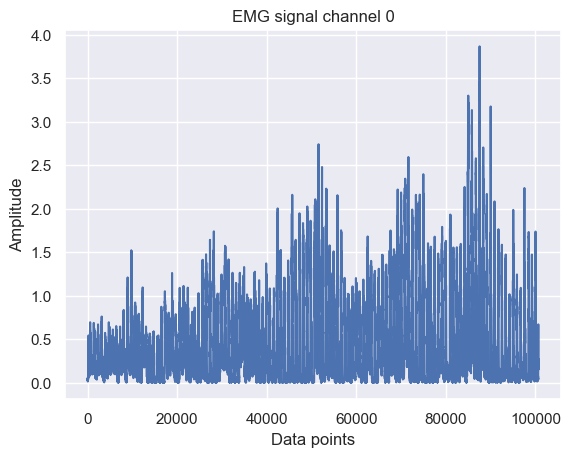

In [6]:
# Plot first channel to get a sense of the data
plt.close("all")
fig, ax = plt.subplots()
EMG_channel = 0
ax.plot(emg[:, EMG_channel])   
ax.set_title(f"EMG signal channel {EMG_channel}")
ax.set_xlabel("Data points")
ax.set_ylabel("Amplitude")

### Visualize all channels

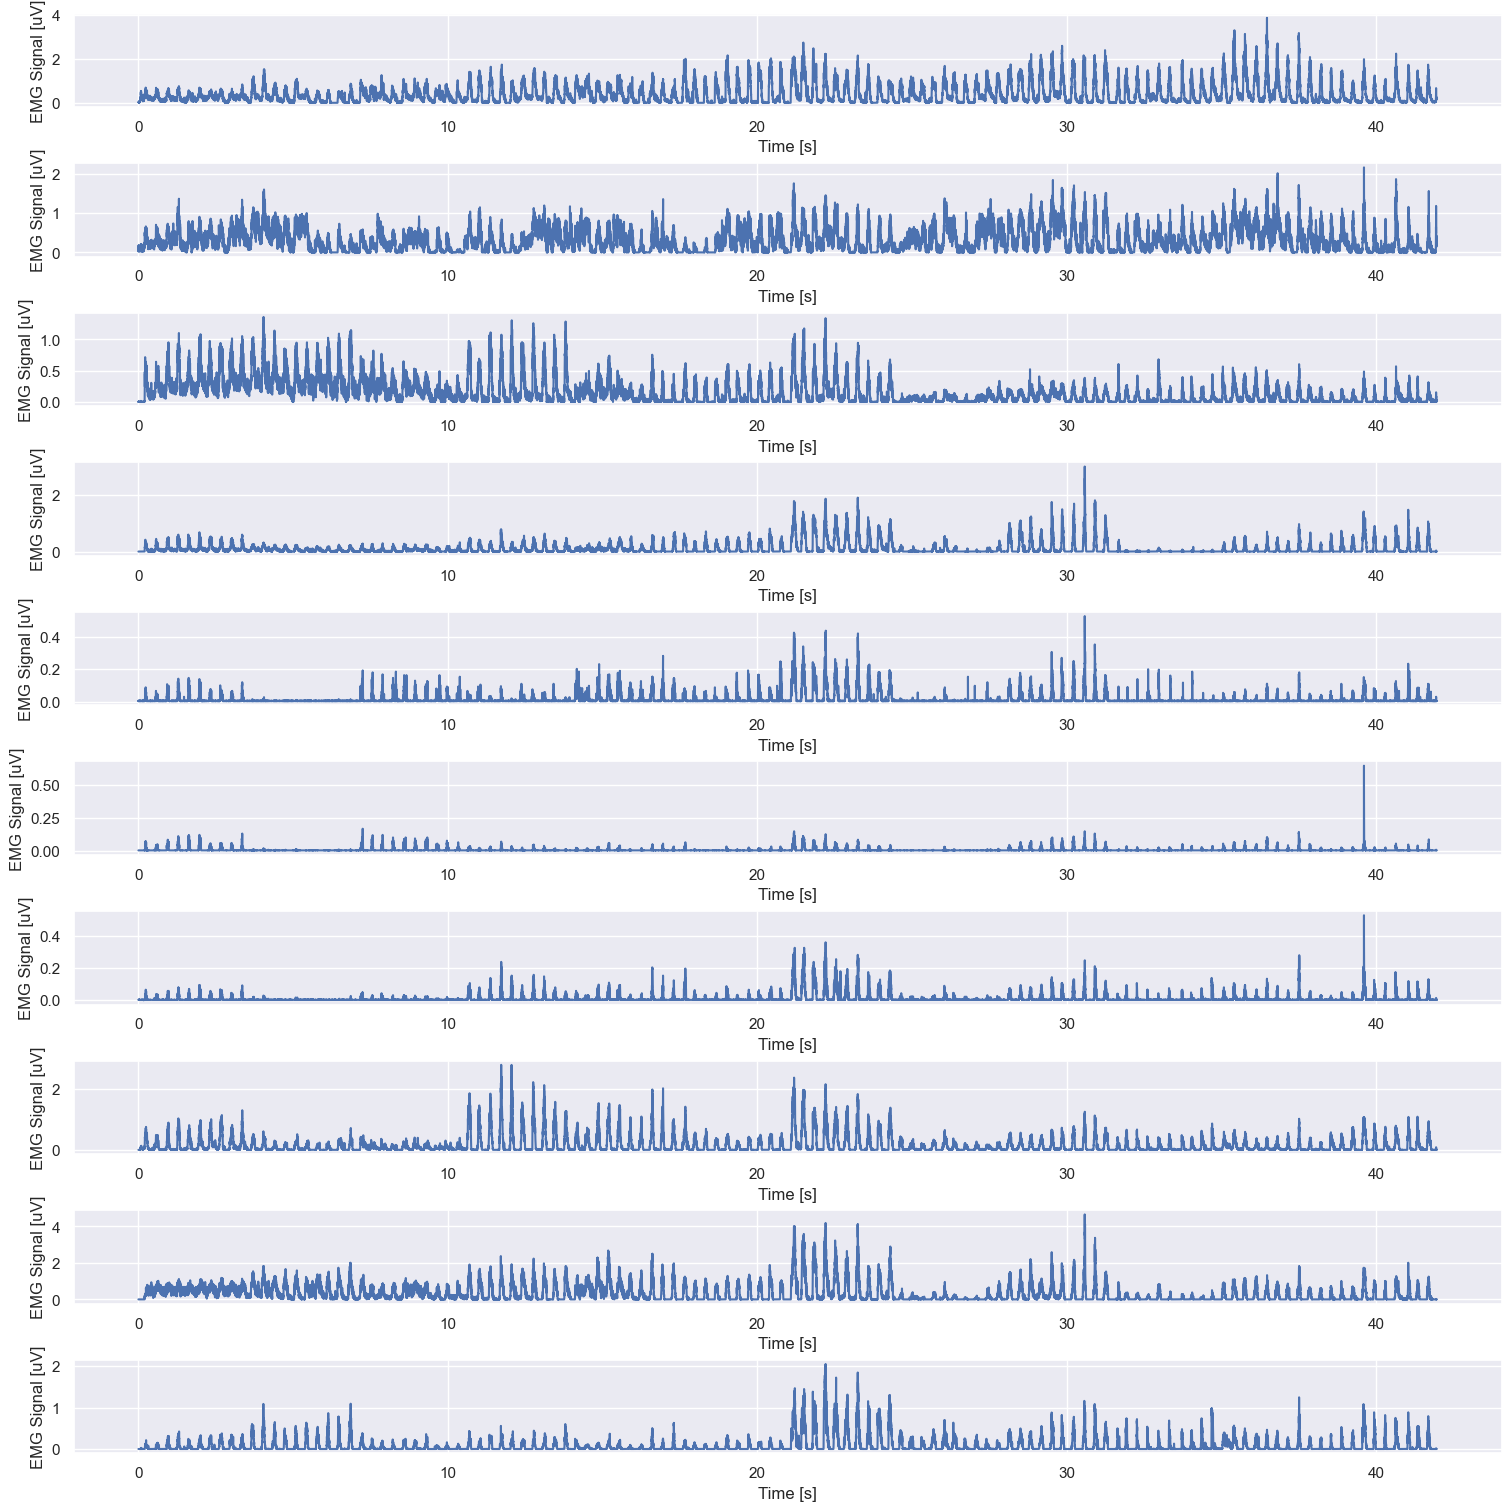

In [7]:
# Sampling frequency (Hz)
fs = 2400 
n_channels = emg.shape[1]

time_steps = np.arange(0,emg.shape[0]/fs, 1/fs) #Time vector for plotting

fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 15))
for channel_idx in range(n_channels):
    ax[channel_idx].plot(time_steps, emg[:, channel_idx])
    ax[channel_idx].set_xlabel("Time [s]")
    ax[channel_idx].set_ylabel("EMG Signal [uV]")

Already partially preprocessed ! Already filtered and rectified

## Preprocess data

In [8]:
#defining the length of the moving average window
mov_mean_length = 25
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

#initializing the data structure
emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        idx = np.logical_and(stimulus == stimuli_idx + 1, repetition == repetition_idx + 1).flatten()
        emg_windows[stimuli_idx][repetition_idx] = emg[idx, :]
        emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], mov_mean_weights, axis=0) 

Text(0.5, 0.98, 'Envelopes of the EMG signal')

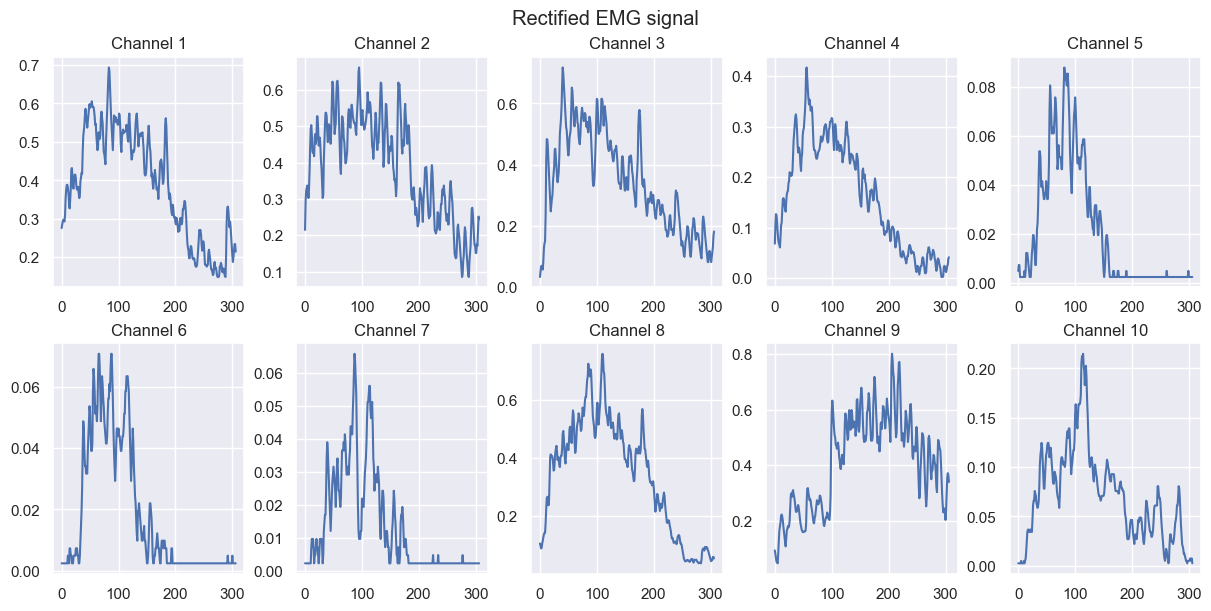

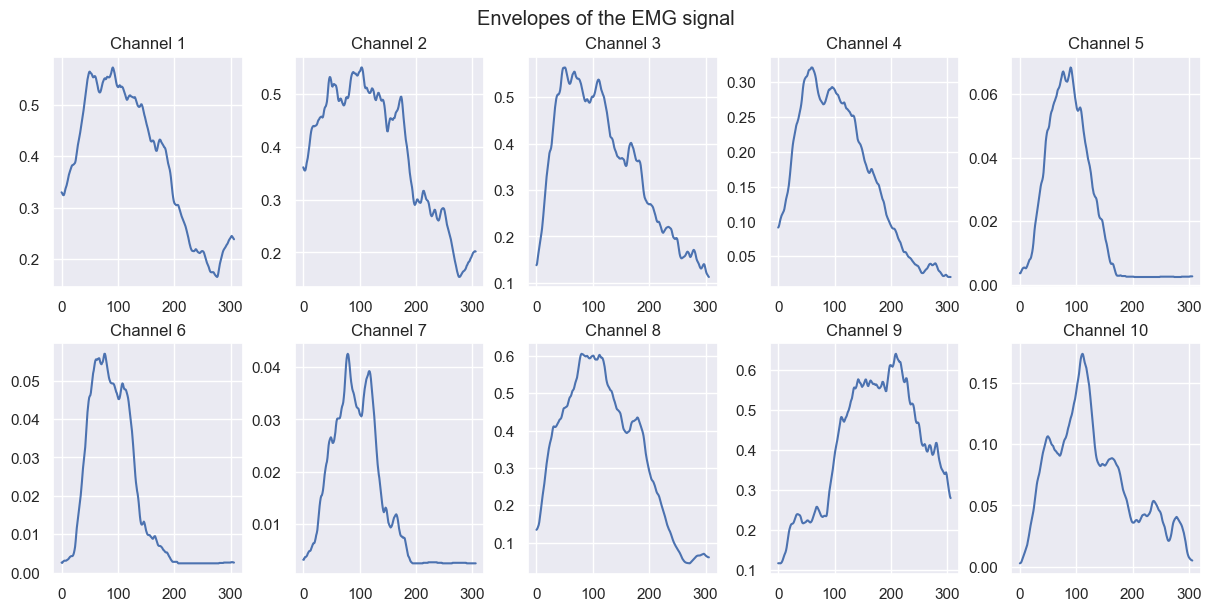

In [9]:
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
ax = ax.ravel()

#10 EMG channels
number_of_emg_channels = emg.shape[-1]
# plot Rectified EMG signal
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal")

# plot Envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
ax = ax.ravel()
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Envelopes of the EMG signal")

The data looks good ! Chanel 5, 6 and 7 doesn't take a lot of data after 200 timesteps. No other aquisition problems.

Text(0.5, 0.98, 'Envelopes of the EMG signal')

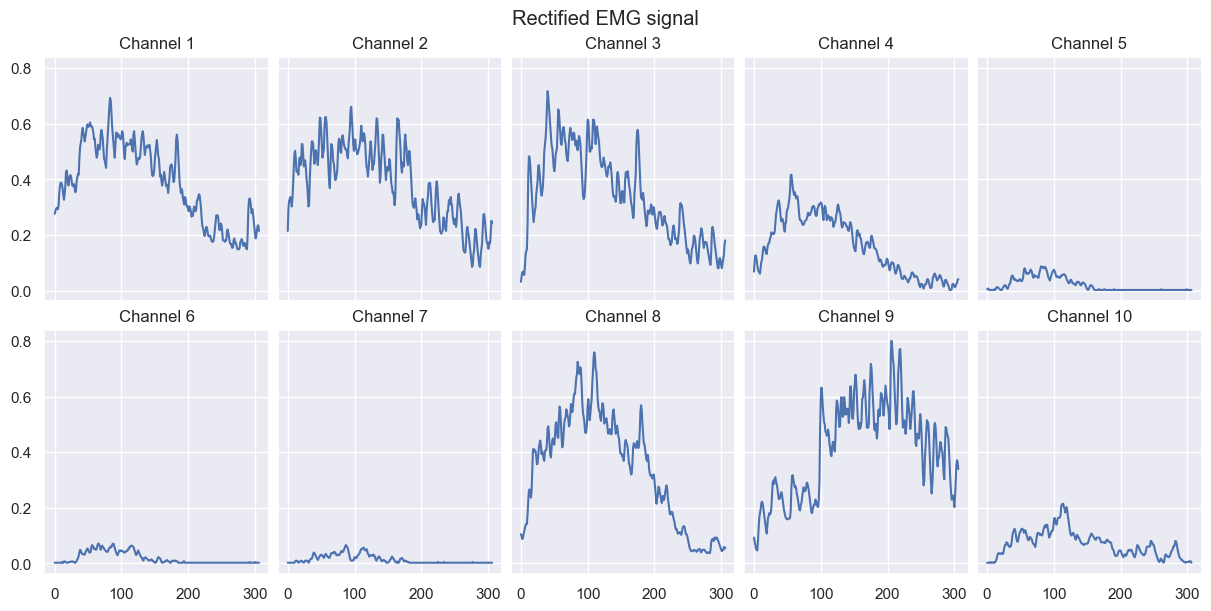

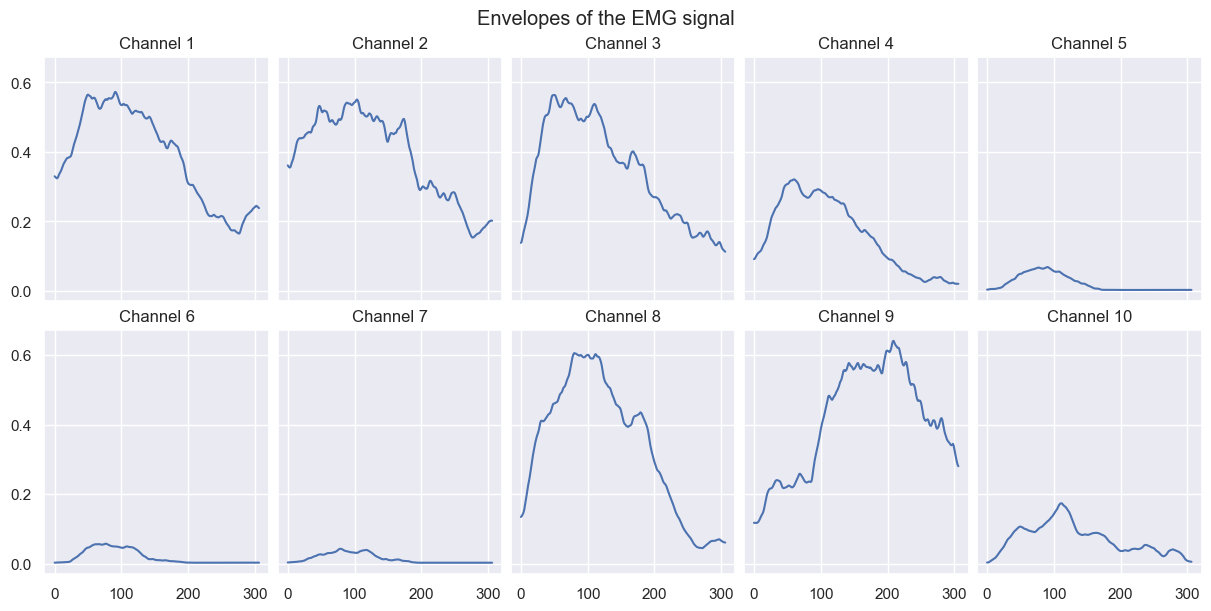

In [10]:
# Now we plot all the channels on the same y-scale
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

number_of_emg_channels = emg.shape[-1]
# plot Rectified EMG signal
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal")

# plot Envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Envelopes of the EMG signal")

In fact, channel 5, 6 and 7 have low signal comparing to the rest of the channels. they may only take noise. 

## Visualize across repetitions

In [11]:
emg_average_activations = np.zeros((n_channels, n_stimuli, n_repetitions))
for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        #mean across time for each channel
        emg_average_activations[:, stimuli_idx, repetition_idx] = np.mean(emg_envelopes[stimuli_idx][repetition_idx], axis=0) 

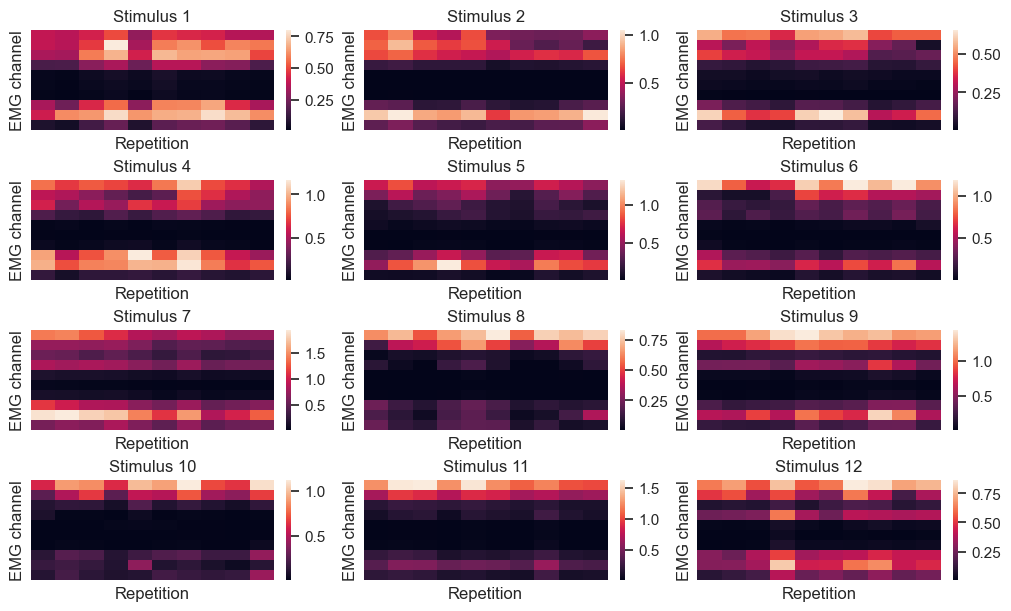

In [12]:
fig, ax = plt.subplots(4, 3, figsize=(10, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

for stimuli_idx in range(n_stimuli):
    sns.heatmap(np.squeeze(emg_average_activations[:, stimuli_idx, :]), ax=ax[stimuli_idx] ,xticklabels=False, yticklabels=False, cbar = True)
    ax[stimuli_idx].title.set_text("Stimulus " + str(stimuli_idx + 1))
    ax[stimuli_idx].set_xlabel("Repetition")
    ax[stimuli_idx].set_ylabel("EMG channel")

We also observe that channel 5,6,7 do not varie between trials. They are not capturing significant signals. Other channel are capturing activity !

# Extract the features

In [14]:
def build_dataset_from_ninapro(emg, stimulus, repetition, features=None):
    # Calculate the number of unique stimuli and repetitions, subtracting 1 to exclude the resting condition
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    # Total number of samples is the product of stimuli and repetitions
    n_samples = n_stimuli * n_repetitions
    
    # Number of channels in the EMG data
    n_channels = emg.shape[1]
    # Calculate the total number of features by summing the number of channels for each feature
    n_features = sum(n_channels for feature in features)
    
    # Initialize the dataset and labels arrays with zeros
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0
    
    # Loop over each stimulus and repetition to extract features
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            # Assign the label for the current sample
            labels[current_sample_index] = i + 1
            # Calculate the current sample index based on stimulus and repetition
            current_sample_index = i * n_repetitions + j
            current_feature_index = 0
            # Select the time steps corresponding to the current stimulus and repetition
            selected_tsteps = np.logical_and(stimulus == i + 1, repetition == j + 1).squeeze()
            
            # Loop over each feature function provided
            for feature in features:
                # Determine the indices in the dataset where the current feature will be stored
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                # Apply the feature function to the selected EMG data and store the result
                dataset[current_sample_index, selected_features] = feature(emg[selected_tsteps, :])
                # Update the feature index for the next feature
                current_feature_index += n_channels

            # Move to the next sample
            current_sample_index += 1
            
    # Return the constructed dataset and corresponding labels
    return dataset, labels

In [15]:
# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)

# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0)

# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0)

# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))

# Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)

# Slope sign changes (SSC)
ssc = lambda x: np.sum(
    ((x[1:-1] - x[:-2]) * (x[2:] - x[1:-1])) < 0,
    axis=0
)

# You can now add more features, such as frequency domain features, if desired

# Using the dataset function with the implemented features
dataset, labels = build_dataset_from_ninapro(
    emg=emg,
    stimulus=stimulus,
    repetition=repetition,
    features=[mav, std, maxav, rms, wl, ssc]  # Include all features once implemented
)

print(f"dataset dimension: {dataset.shape}")
print(f"labels dimension: {labels.shape}")

dataset dimension: (120, 60)
labels dimension: (120,)


In fact, we have 6 features and 10 channels. We have 60 value per training point. (We may remove channel 5, 6, 7)

Let's look at the features

In [56]:
features=["mav", "std", "maxav", "rms", "wl", "ssc"]
nb_features = len(features)
col = [f"channel {i}" for i in range(1, n_channels+1)]

DataMean = pd.DataFrame(dataset.mean(axis = 0).reshape(nb_features,n_channels),columns=col, index=features)
DataMean

channel 1  channel 2  channel 3  channel 4  channel 5  channel 6  \
mav     0.785619   0.508316   0.284548   0.241694   0.032901   0.011273   
std     0.334891   0.204156   0.130233   0.156042   0.030619   0.012098   
maxav   1.504780   1.007951   0.603704   0.602418   0.129908   0.054385   
rms     0.857988   0.553109   0.315941   0.290621   0.045544   0.016772   
wl     11.022289  11.188974   5.919135   4.459515   1.079146   0.383852   
ssc    93.808333  94.875000  80.016667  65.408333  37.100000  17.125000   

       channel 7  channel 8  channel 9  channel 10  
mav     0.023714   0.357725   0.656261    0.194577  
std     0.023264   0.217378   0.343083    0.140131  
maxav   0.095215   0.852847   1.440978    0.549623  
rms     0.033493   0.421102   0.747811    0.242134  
wl      0.773692   6.000327  13.440092    4.211708  
ssc    29.441667  74.458333  83.891667   63.175000

Text(0.5, 0.98, 'Rectified EMG signal')

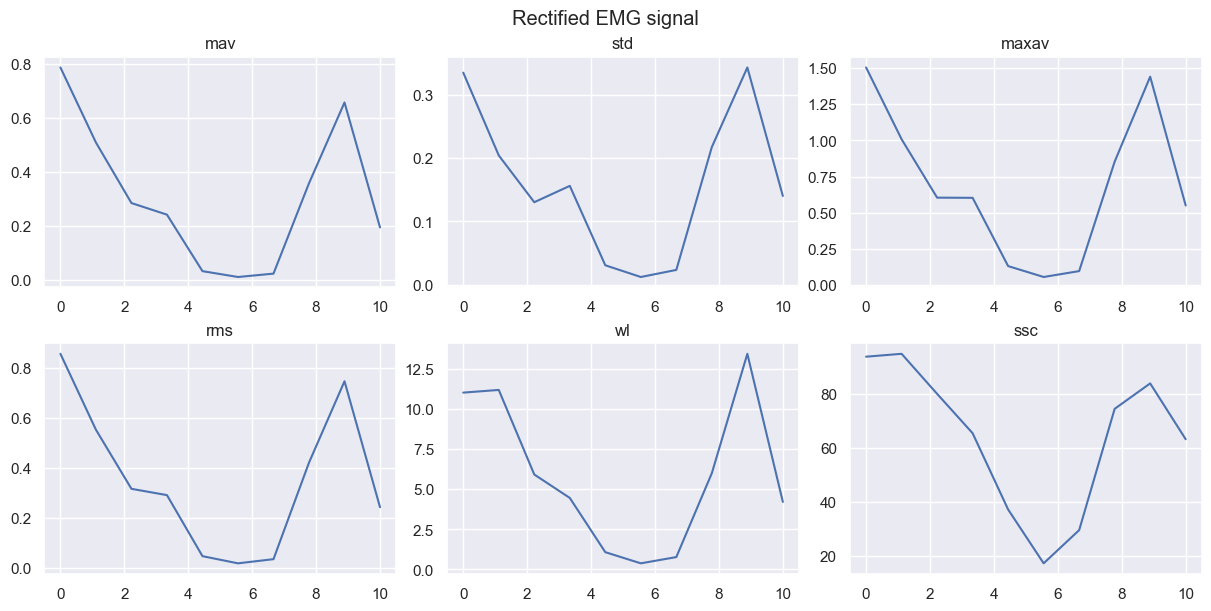

In [65]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6), constrained_layout=True)
ax = ax.ravel()

# plot Rectified EMG signal
for feature in range(nb_features): 
    ax[feature].plot(np.linspace(0,n_channels,n_channels),DataMean.iloc[feature])
    ax[feature].set_title(features[feature])
plt.suptitle("Mean on each chanel")

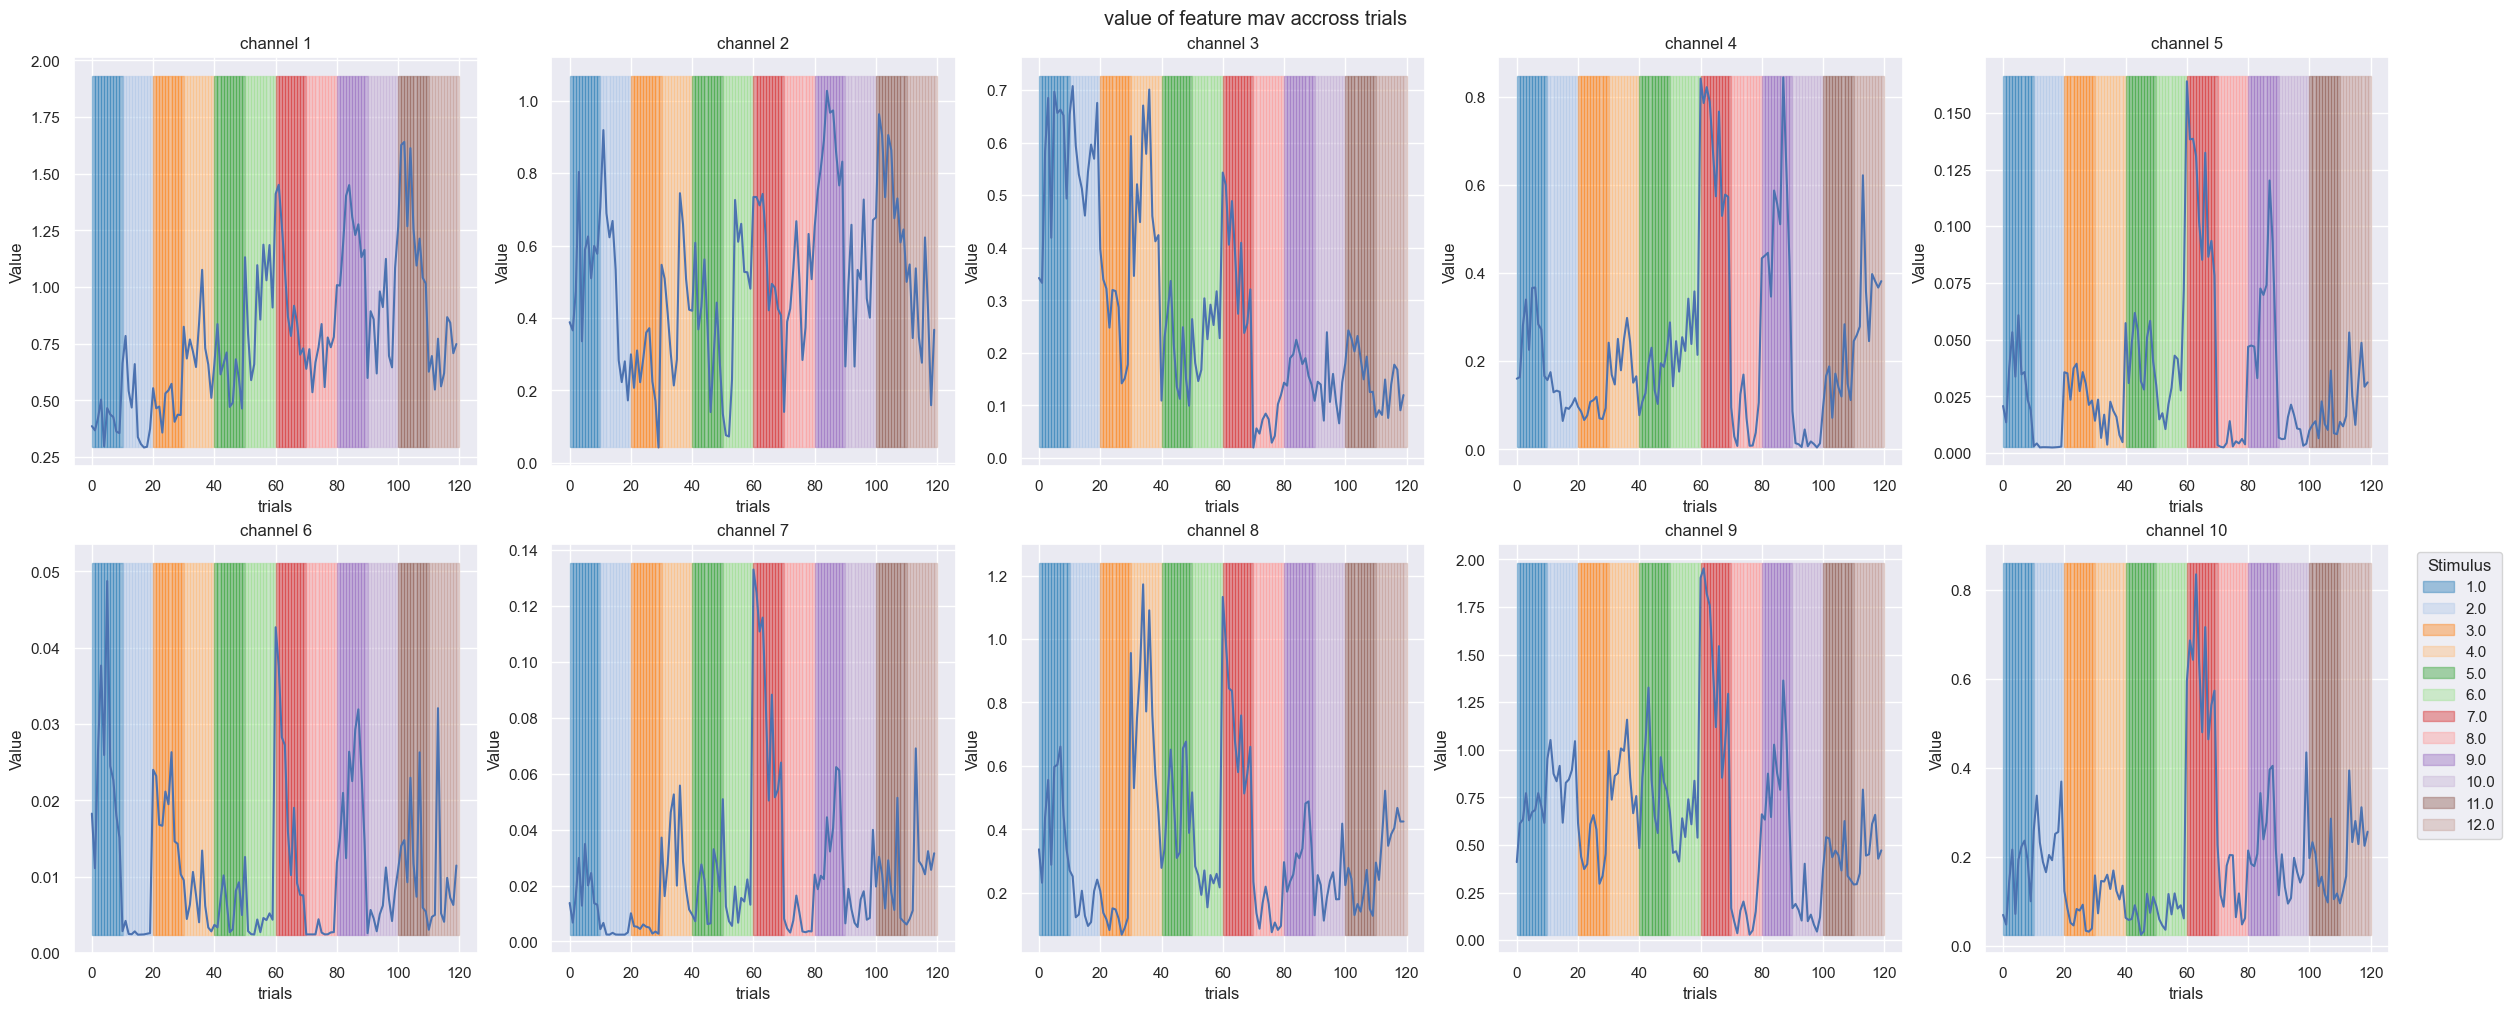

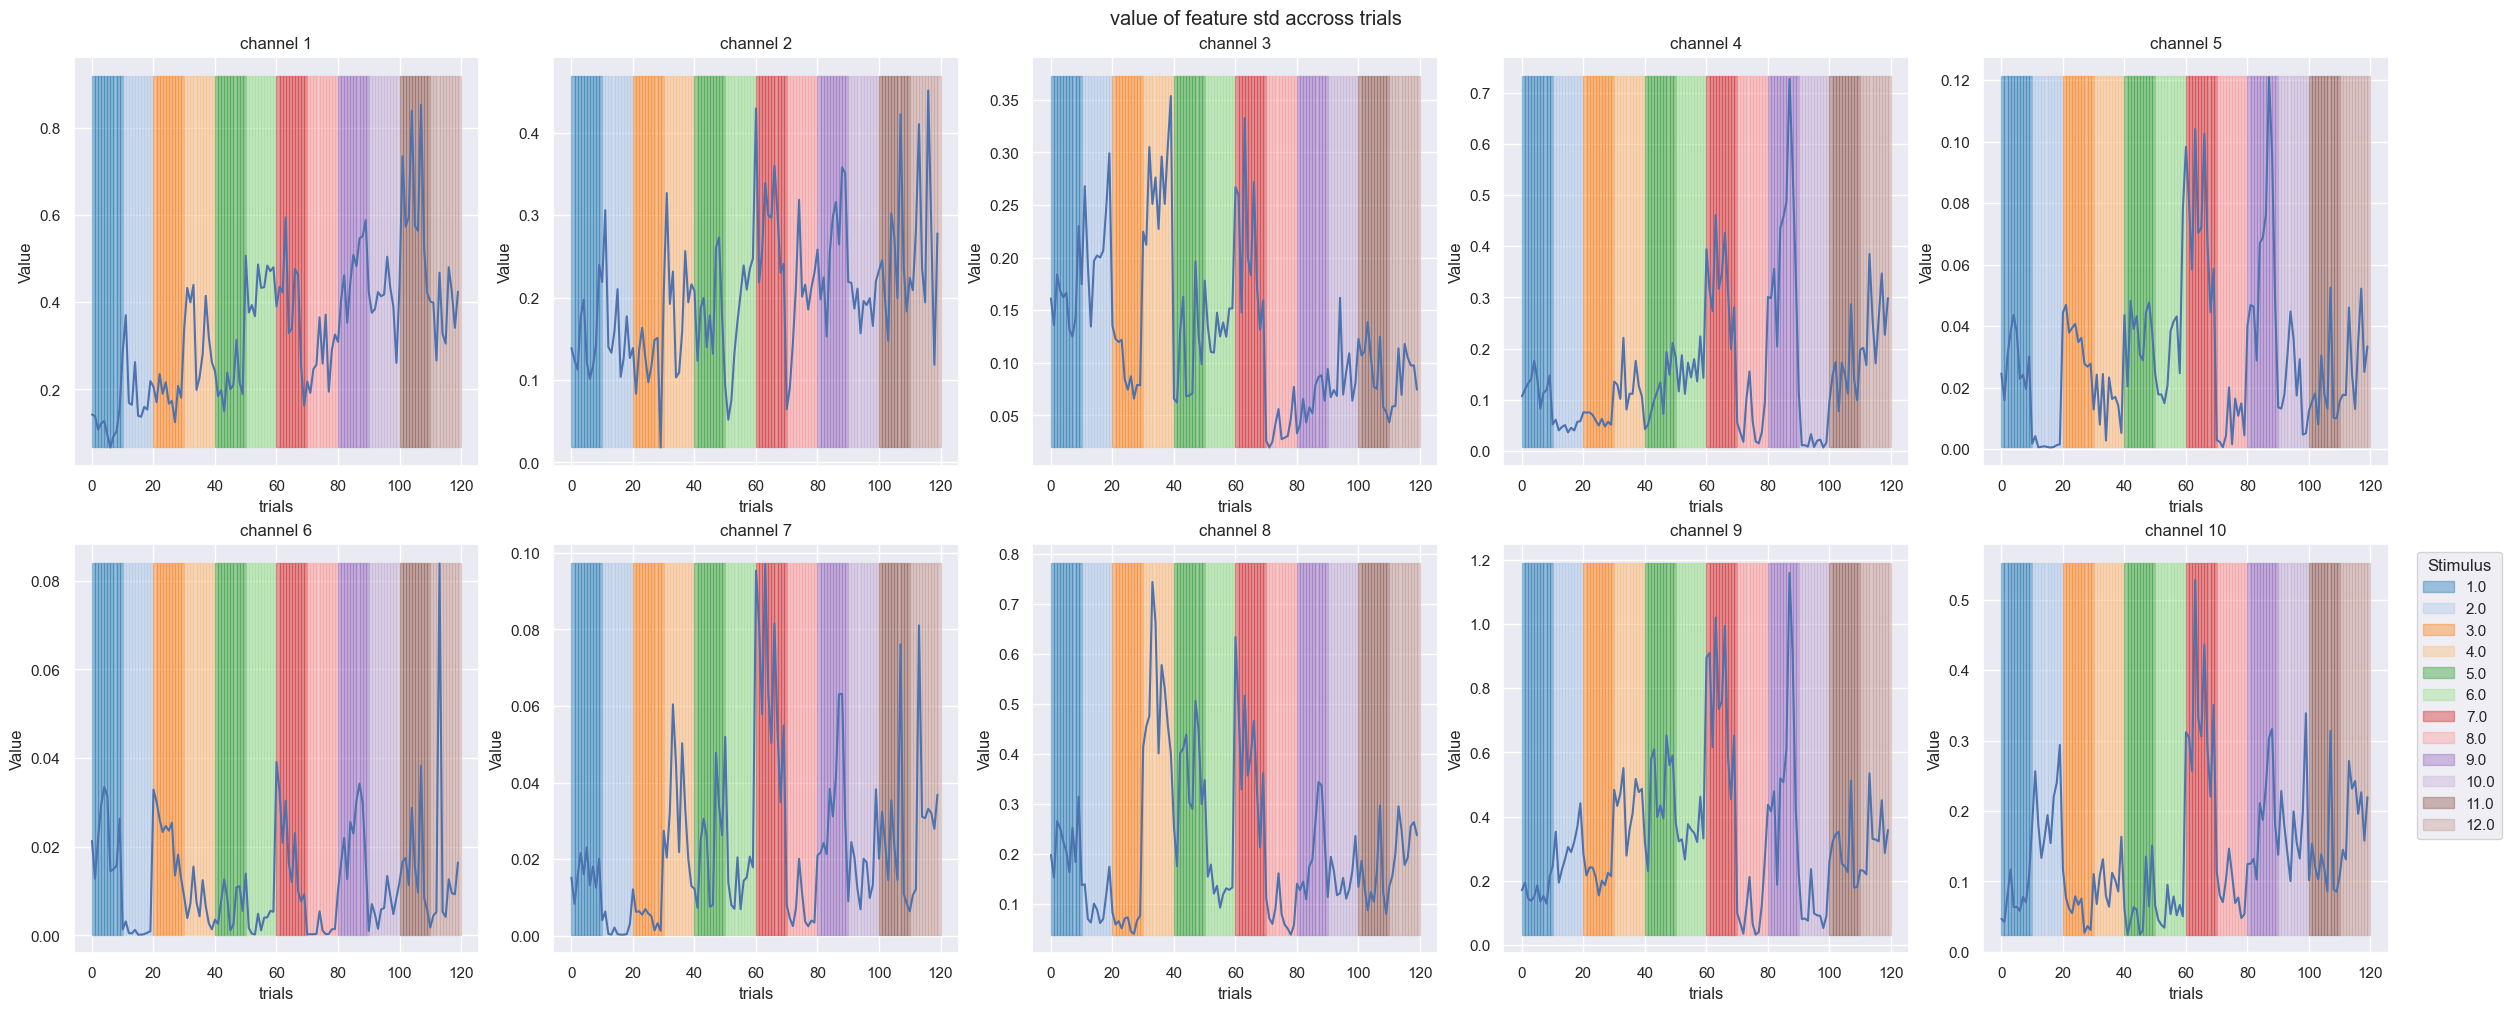

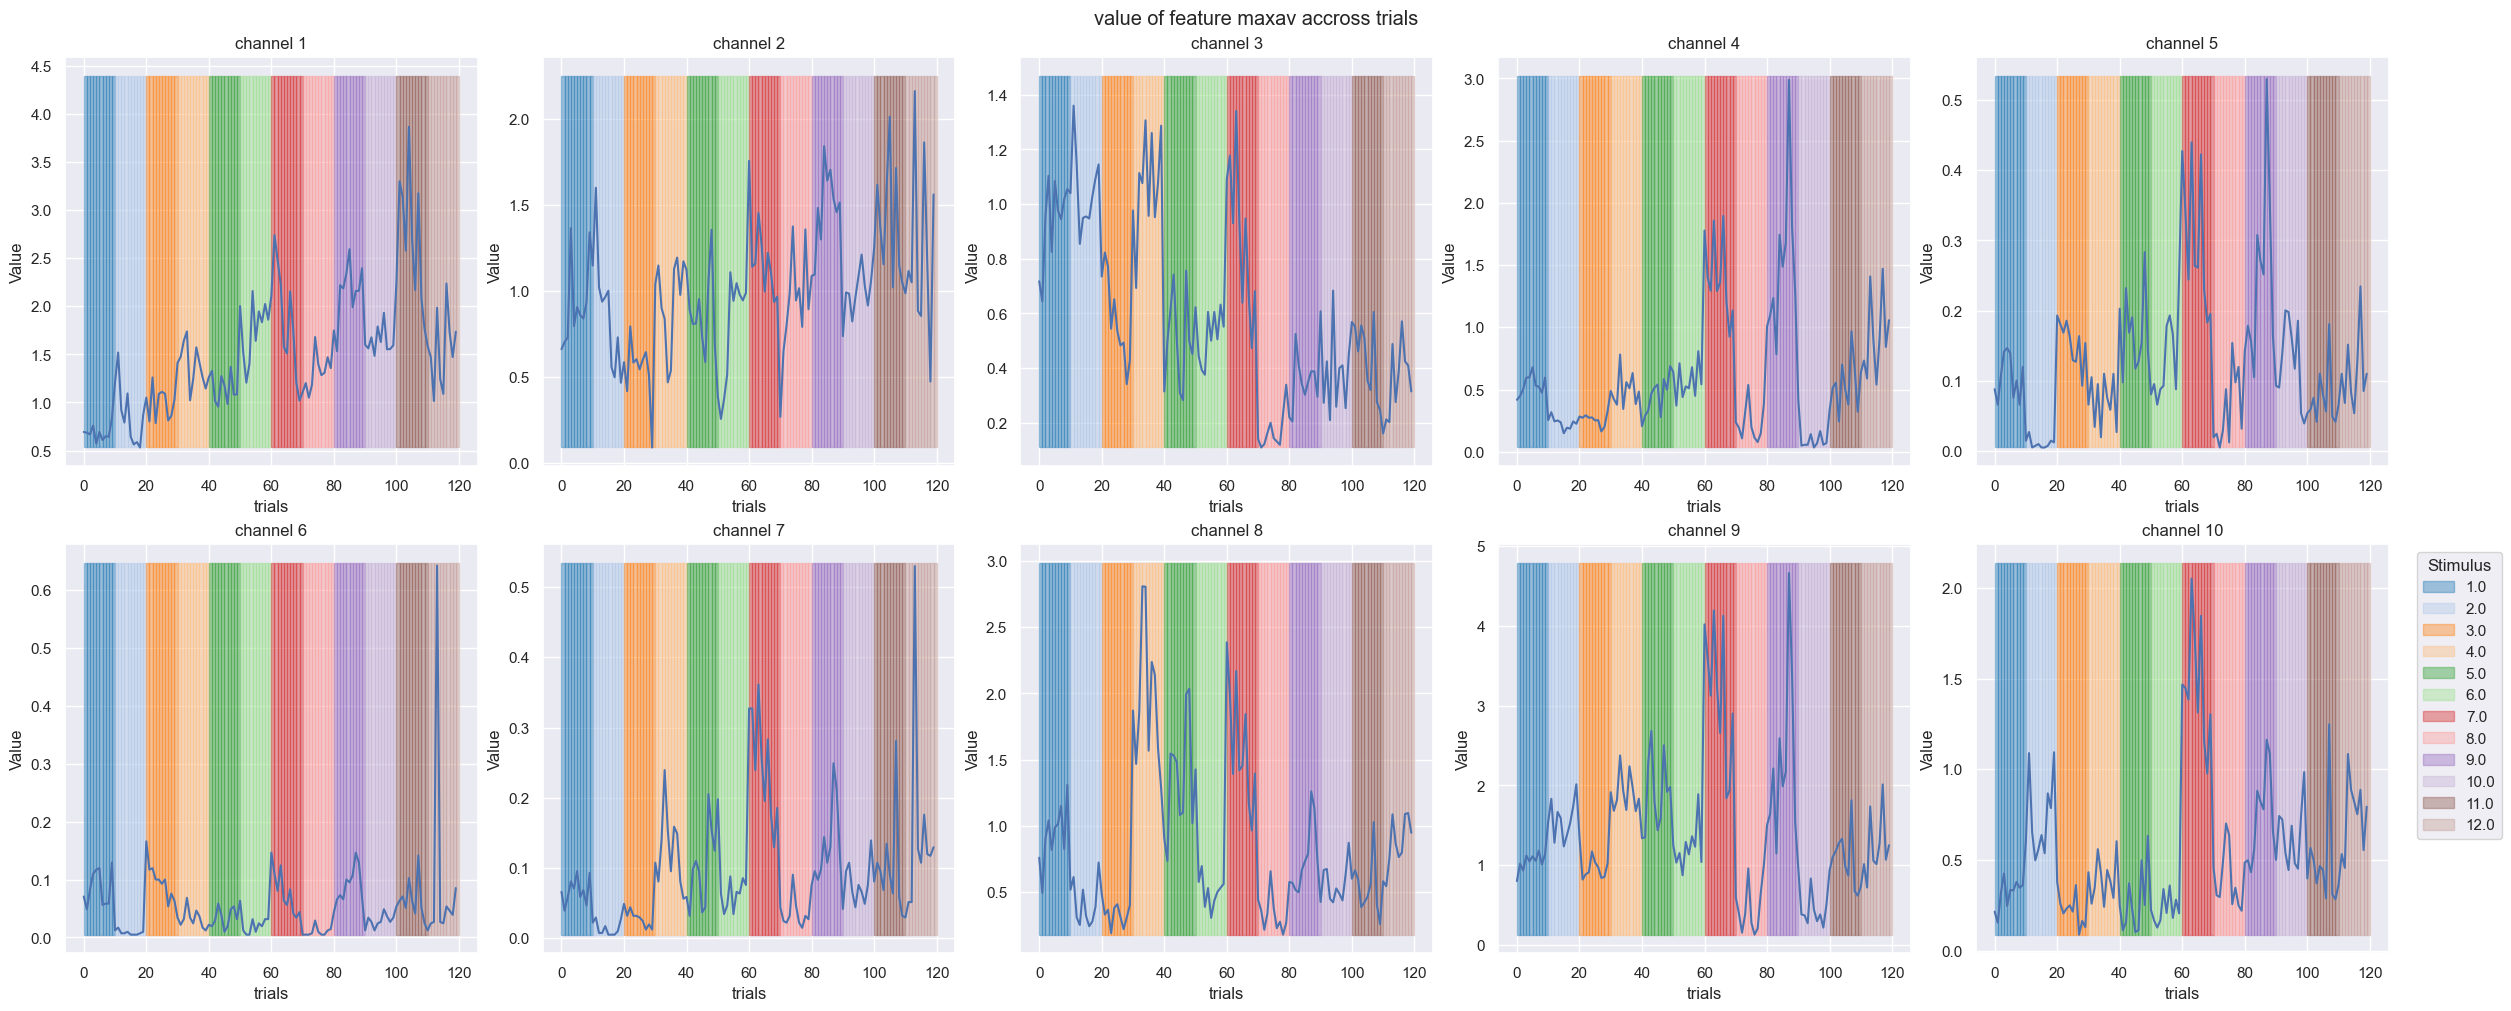

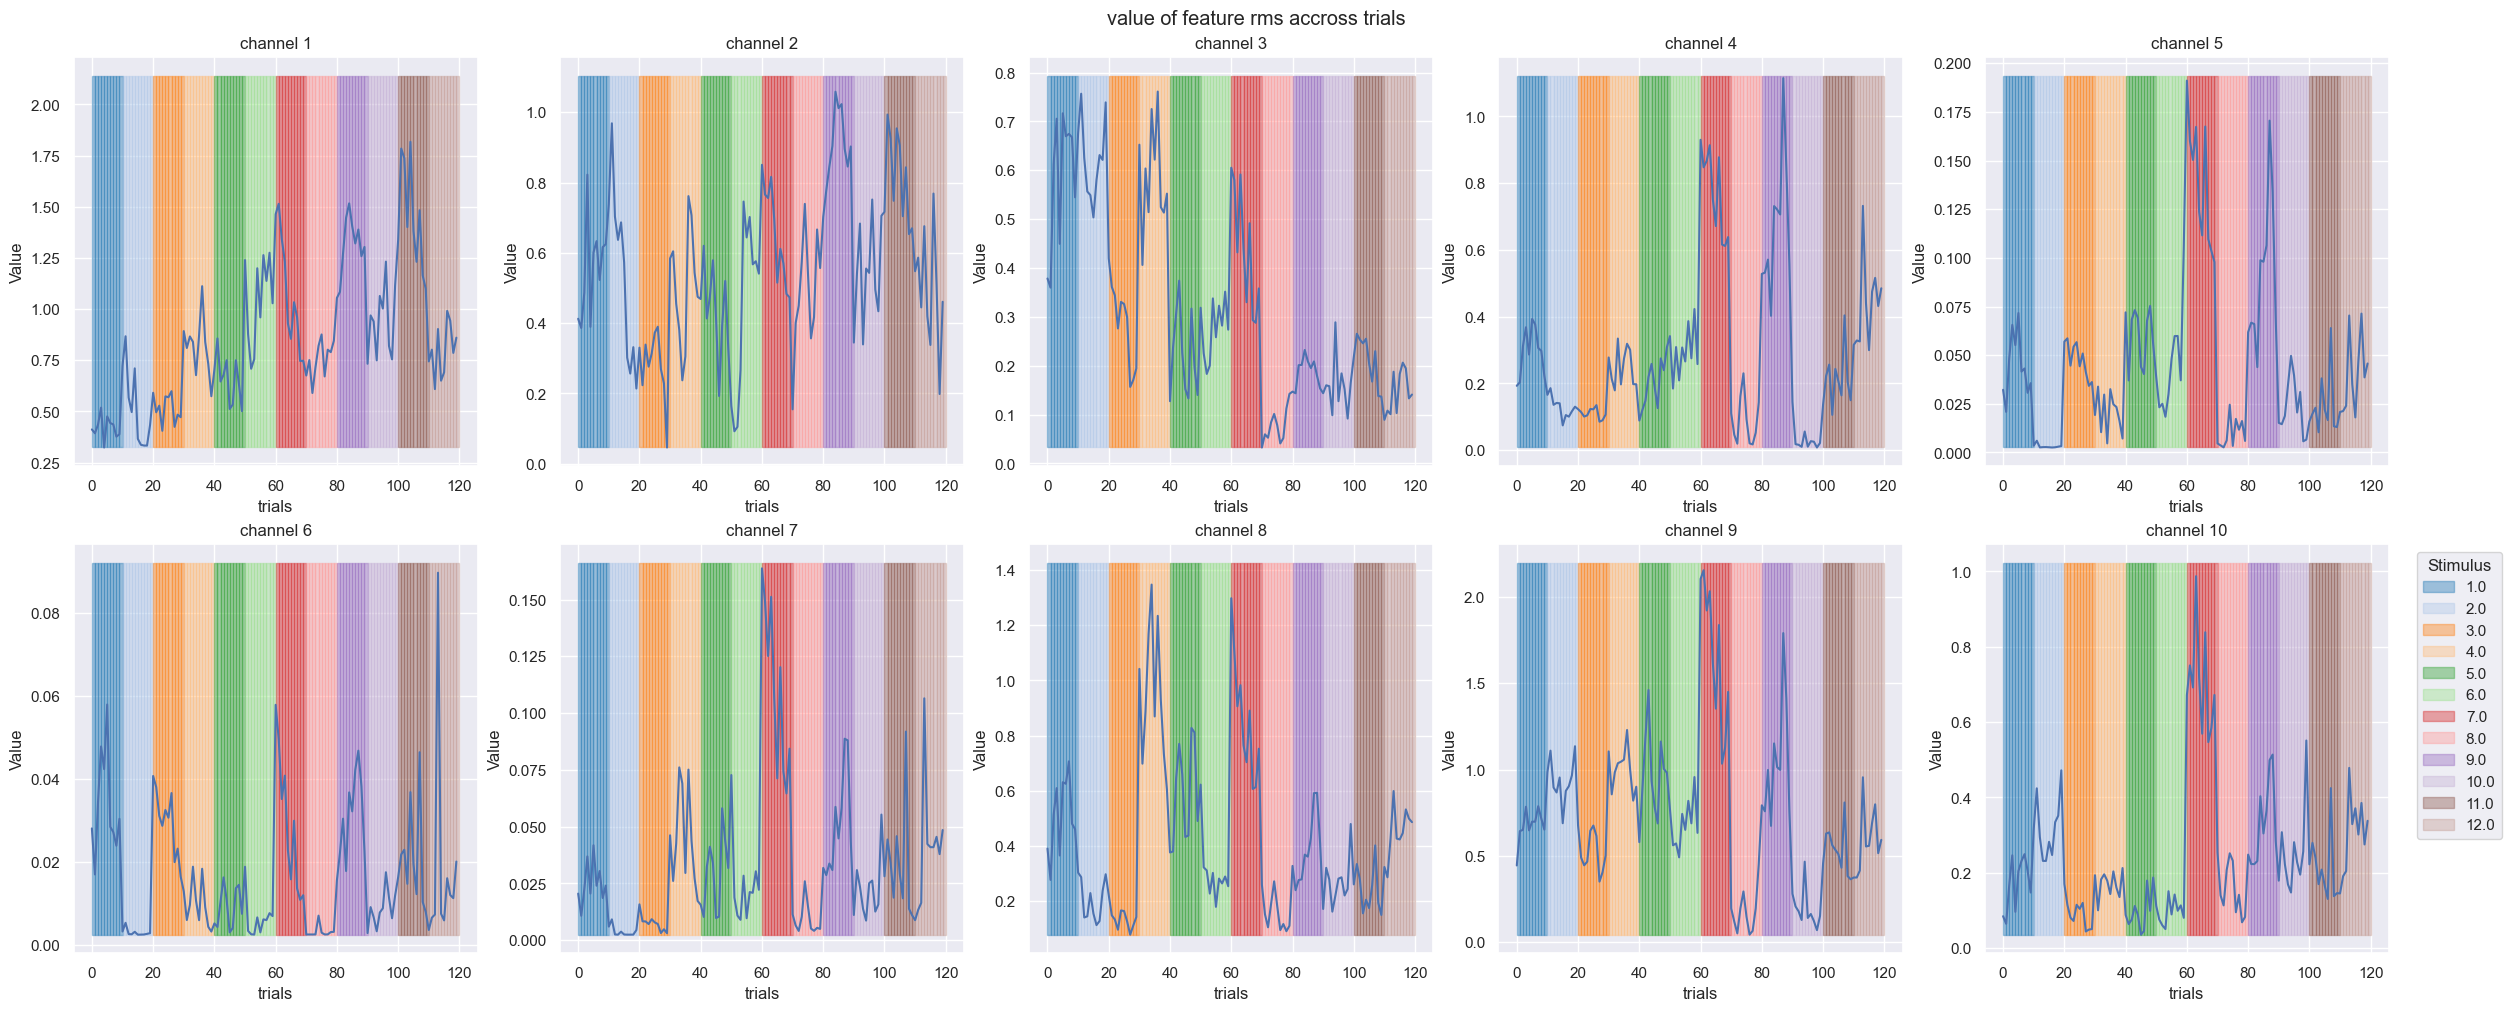

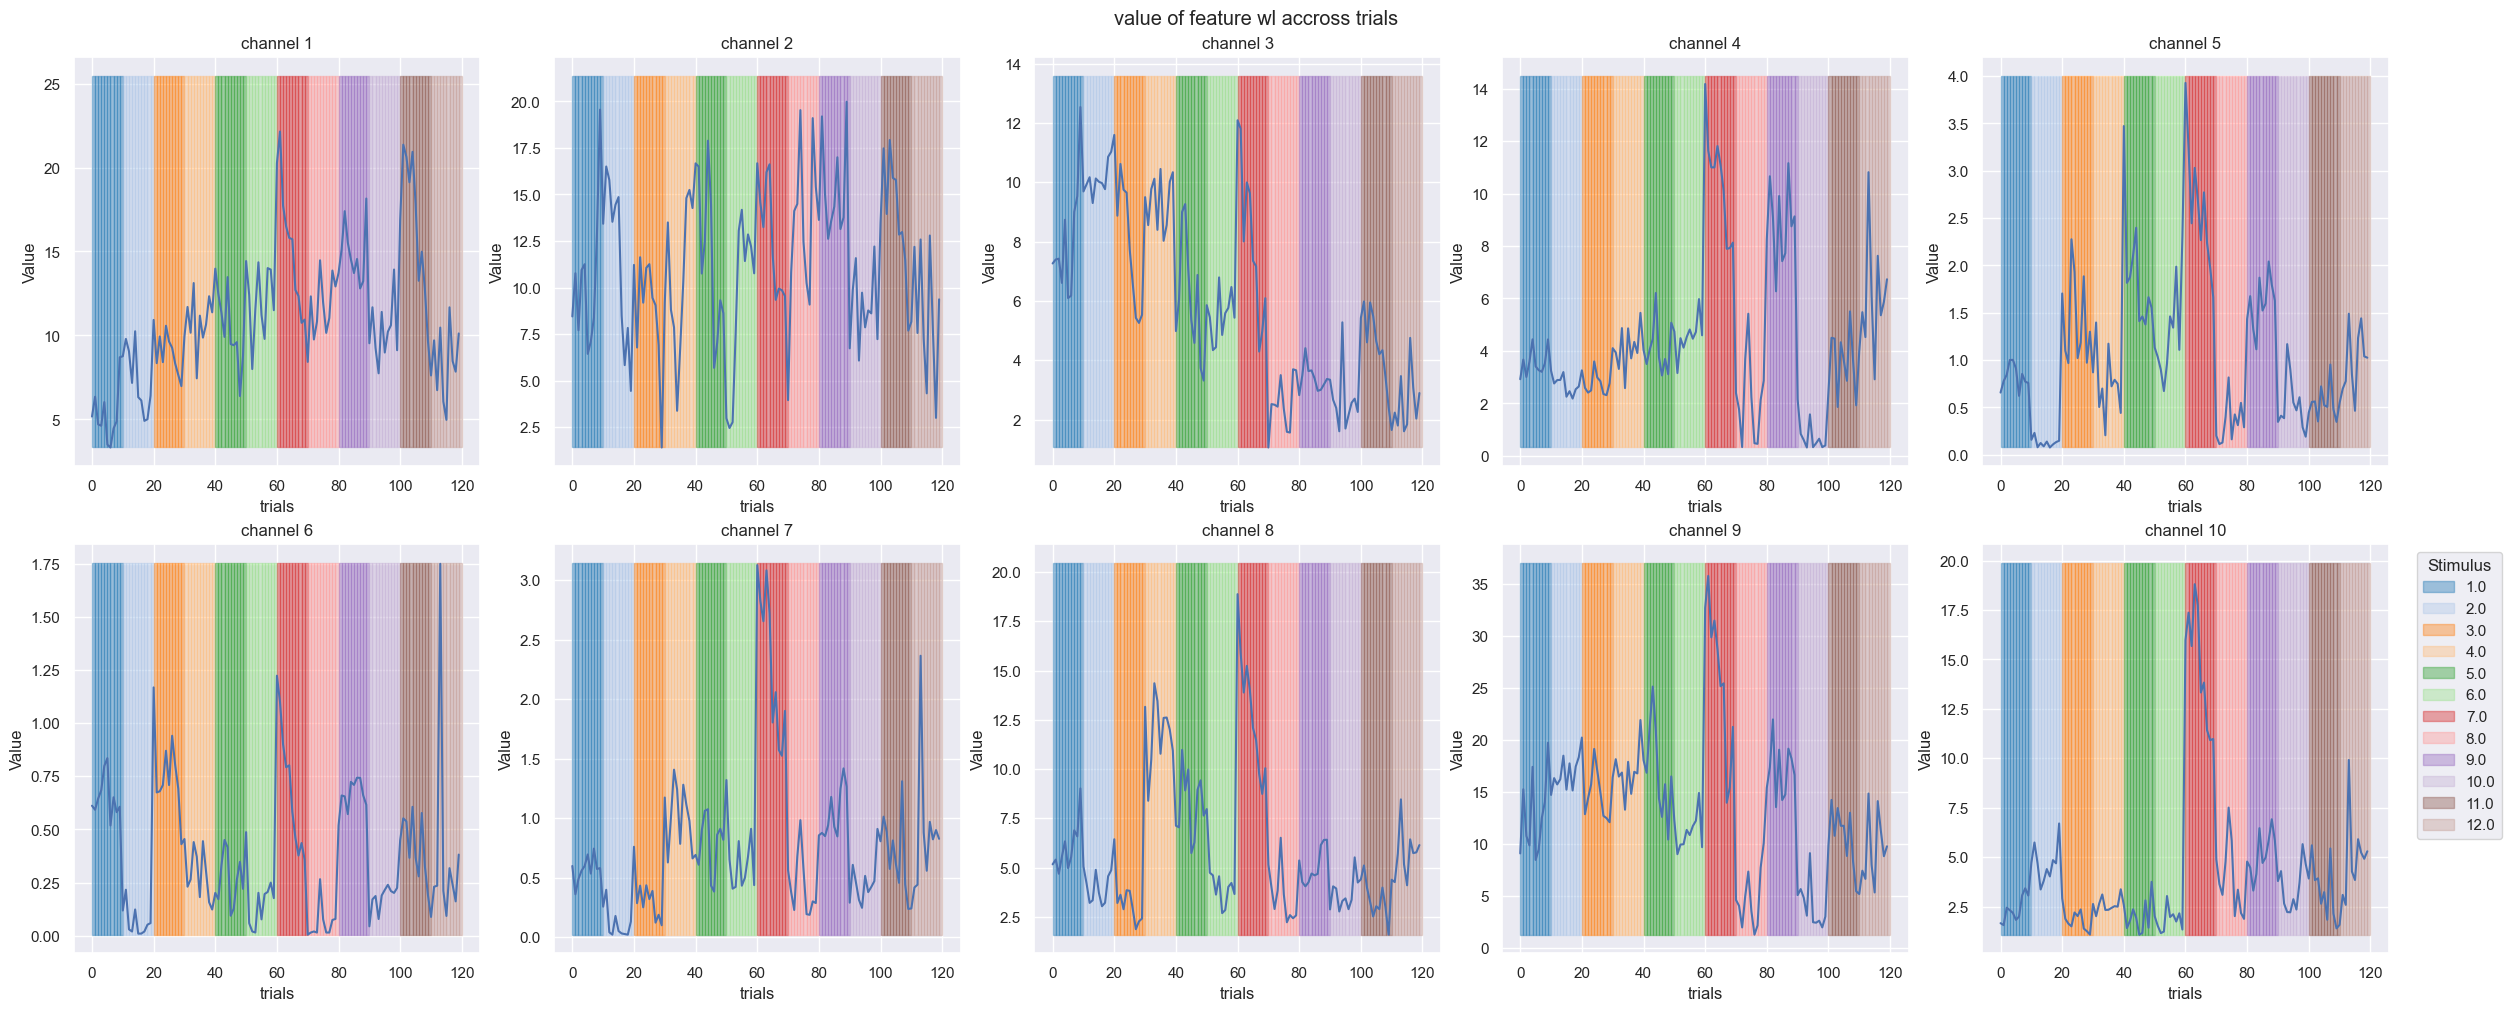

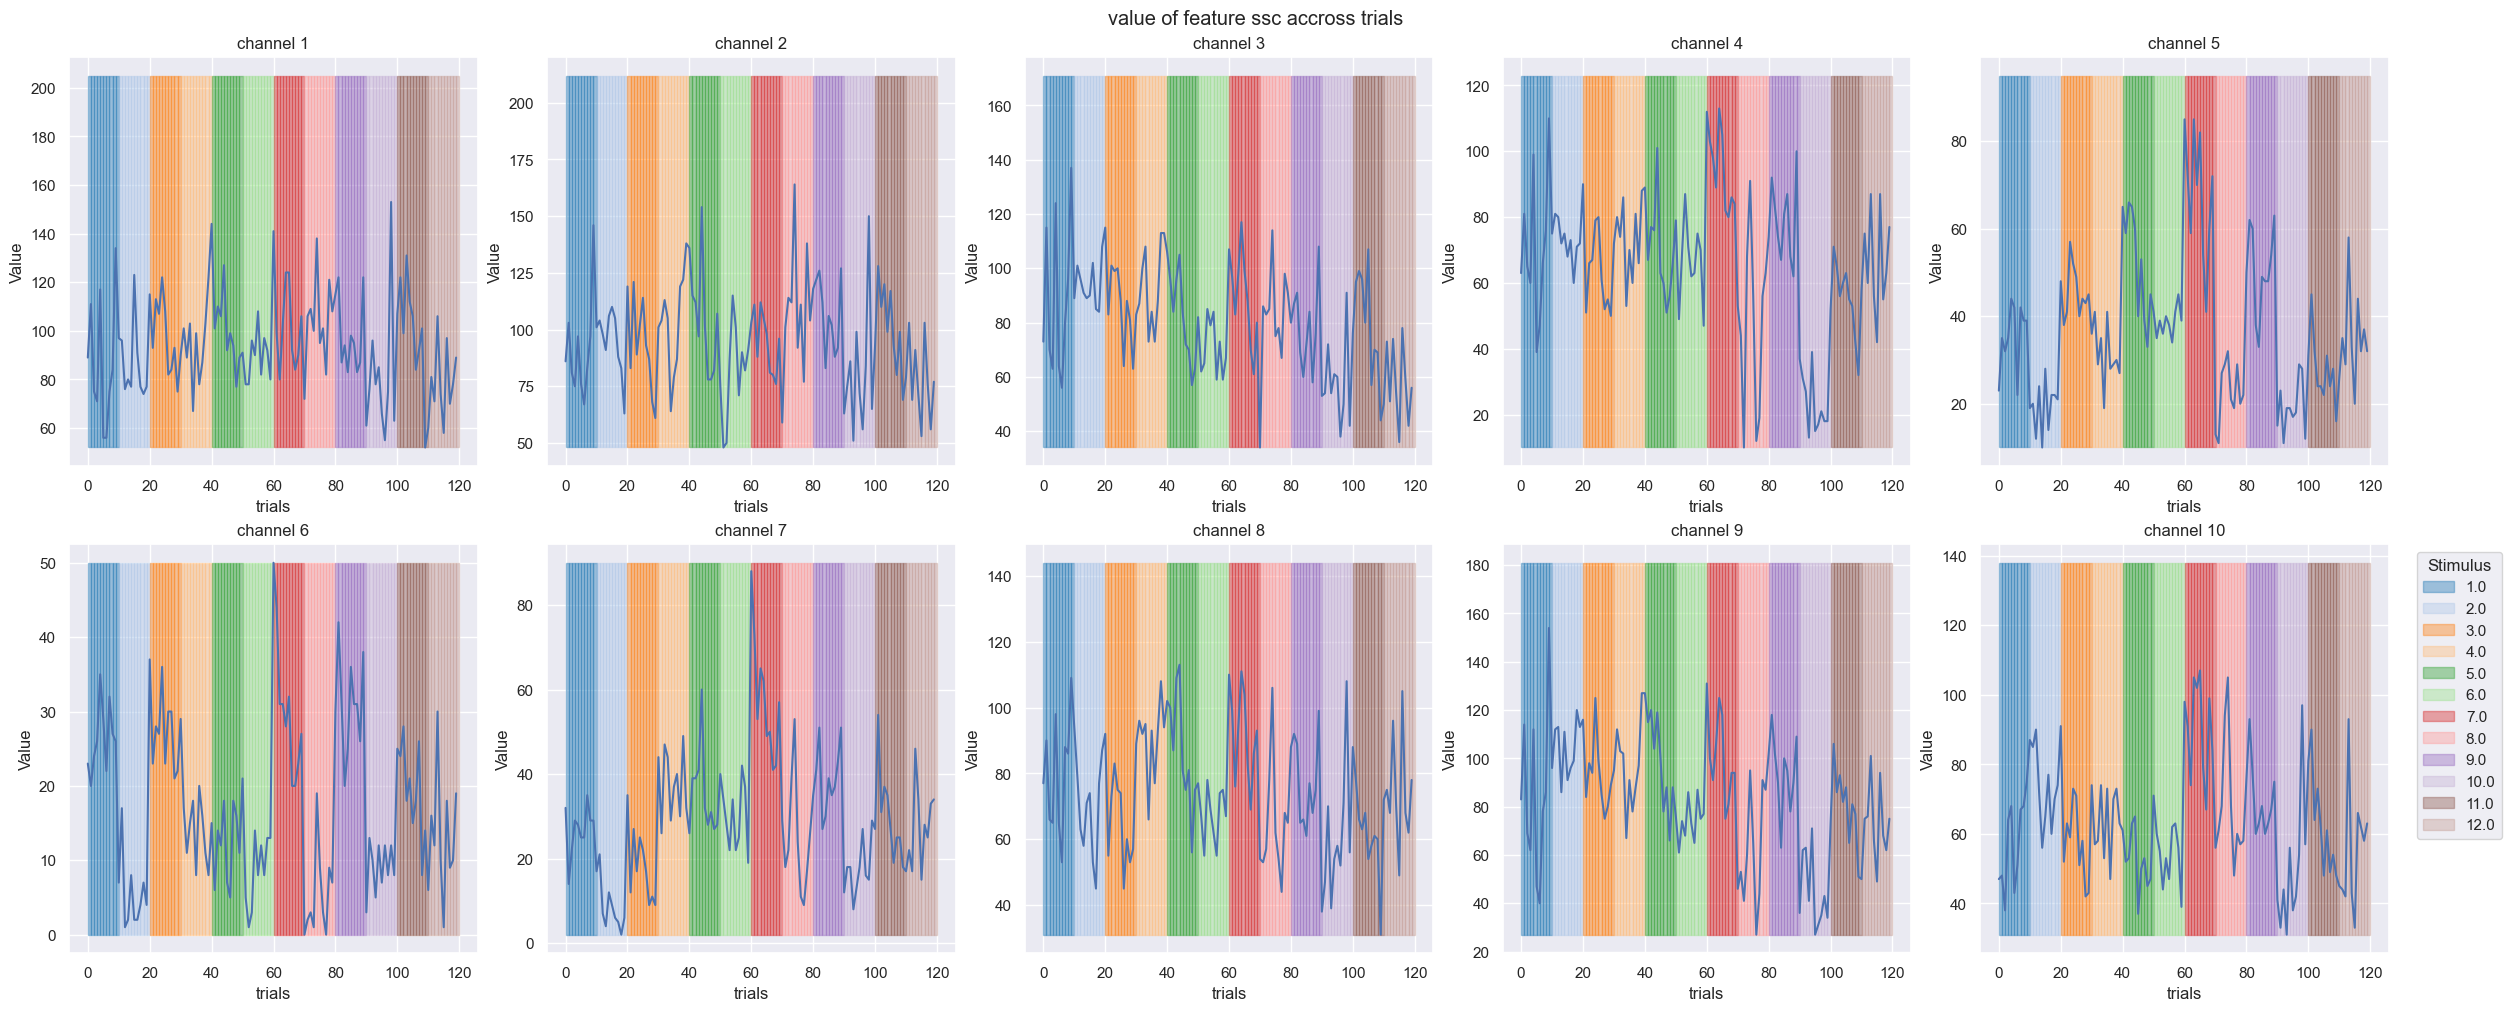

In [115]:
from matplotlib.patches import Rectangle

colors = sns.color_palette("tab20", n_colors=12) 

for feature_nb,feature in enumerate(features) : 
    fig, ax = plt.subplots(2, 5, figsize=(25, 10), constrained_layout=True)
    ax = ax.ravel()
    
    for channel in range(n_channels):
        # Draw stimulus
        dataplot = dataset[:,channel+(feature_nb*n_channels)]
        for i, label in enumerate(labels):
            rect = Rectangle((i, min(dataplot)), 1, max(dataplot), color=colors[int(label - 1)], alpha=0.4)  # Background rectangle
            ax[channel].add_patch(rect)
        #add feature
        ax[channel].plot(dataplot)
        ax[channel].set_xlabel("trials")
        ax[channel].set_ylabel("Value")
        ax[channel].set_title("channel {}".format(channel+1))
    
    handles = [Rectangle((0, 0), 1, 1, color=colors[i], alpha=0.4) for i in range(12)]  # Create legend patches
    plt.legend(handles, np.linspace(1,n_stimuli,n_stimuli), title="Stimulus", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.suptitle("value of feature {} accross trials".format(feature))
    plt.show()

# Split the data

In [116]:
X_train, X_test, y_train, y_test = train_test_split(dataset, labels,test_size=0.3)

In [117]:
print("Train shape {}".format(X_train.shape))
print("Test shape {}".format(X_test.shape))

Train shape (84, 60)
Test shape (36, 60)


# Perform classification

Hyperparameter : n_estimators 

In [145]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)  # Fit the scaler on the training data and transform it
X_test_z = scaler.transform(X_test)        # Transform the test data using the same scaler


param_grid = {
    "n_estimators": range(10, 100, 10),
    "max_features" : ["sqrt", "log2", None],
    "max_depth": range(3,15,5),
    "max_leaf_nodes": range(3,15,5),
}

grid = GridSearchCV(RandomForestClassifier(), param_grid)
grid.fit(X_train_z,y_train)

print(f"Best estimator: {grid.best_estimator_}")
print(f"Best hyperparameters: {grid.best_params_}")

y_pred = grid.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score of best model: {accuracy}")


Best estimator: RandomForestClassifier(max_depth=8, max_leaf_nodes=13, n_estimators=20)
Best hyperparameters: {'max_depth': 8, 'max_features': 'sqrt', 'max_leaf_nodes': 13, 'n_estimators': 20}
Accuracy score of best model: 0.16666666666666666


# Evaluate performance